# Linear [MNIST](https://github.com/pytorch/examples/tree/master/mnist) with [torch](https://pytorch.org/)
stough 202-

Simple torch model with a single [Linear](https://pytorch.org/docs/stable/nn.html#linear)
(or fully connected) layer 
from MNIST images to digit classification. This is simplified from 
the example just to see if torch learns a pretty simple per pixel
prior.

A [fully-connected layer](https://pytorch.org/docs/stable/nn.html#linear) with N inputs and M outputs
solves a simple linear equation: $y = x A^T + b$, with a total of NxM + M parameters to learn.

Additional resources:
- A nice and recent [walkthrough](https://nextjournal.com/gkoehler/pytorch-mnist)

In [1]:
%matplotlib inline
# or widget
import matplotlib.pyplot as plt

import numpy as np
from random import shuffle
import copy
import tempfile

from functools import partial
from multiprocessing.pool import ThreadPool

# from keras.datasets import mnist
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# torch
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torch.nn.functional as F

from torch import nn
from torch.autograd import Variable
from torch.nn import Module

# For timing.
import time
tic, toc = (time.time, time.time)

## Define the Network
The simplest possible network, simple linear.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = self.fc(x) # __call__
        output = F.log_softmax(x, dim=1)
        return output

## Training and Test functions.

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_sum += loss.item()
    
    print('\nTrain set: Average loss: {:.4f}'.format(loss_sum/len(train_loader.dataset)))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Namespace to replace the argparse business

In [4]:
from argparse import Namespace
# What is a Namespace? It looks like this. 
# Such objects allow you to use the dot operator, like a struct in C.
# class Namespace:
#     def __init__(self, **kwargs):
#         self.__dict__.update(kwargs)

args = Namespace(
    no_cuda=False, 
    seed=1, 
    batch_size=64,
    test_batch_size=1000,
    epochs=5,
    lr=1.0,
    gamma=0.7,
    log_interval=250,
    save_model=False
)

## Organize the MNIST data

The initial [Dataset](https://pytorch.org/docs/stable/data.html#) object returned implements `__getitem__()` and `__len__()`, and that's it pretty much. Below I collect this data into numpy arrays and use a custom class that inherits from Dataset.  

In [5]:
# Thank you: https://www.aiworkbox.com/lessons/load-mnist-dataset-from-pytorch-torchvision
# https://pytorch.org/docs/stable/torchvision/datasets.html
mnist_trainset = datasets.MNIST(root='/home/dip365/data', train=True, download=False, transform=None)
mnist_testset = datasets.MNIST(root='/home/dip365/data', train=False, download=False, transform=None)

x_train = np.stack([np.array(x).ravel() for x,_ in mnist_trainset])
x_test = np.stack([np.array(x).ravel() for x,_ in mnist_testset])
y_train = np.stack([y for _,y in mnist_trainset]).astype('long')
y_test = np.stack([y for _,y in mnist_testset]).astype('long')

# These are Nx784
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [6]:
class MNIST_data(Dataset):
    def __init__(self, XY):
        self.x_data = XY[0]
        self.y_data = XY[1]
    
    def __len__(self):
        return self.x_data.shape[0]
    
    def __getitem__(self, idx):
        return (self.x_data[idx], self.y_data[idx])

In [7]:
# input is a list of tuples (one for each input-output pair). 
# output of this function needs to be a single tuple of (inputs, outputs).
def torch_collate(data):
    inputs = np.stack([lyst[0] for lyst in data])
    outputs = np.stack([lyst[1] for lyst in data])
    return torch.from_numpy(inputs), torch.from_numpy(outputs)

&nbsp;

## Make torch DataLoaders for our custom dataset.
After the below code executes, `train_loader` and `test_loader` are torch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) objects that we iterate through to get batches of (N,784) data and (N,) target outputs.

In [8]:
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': False} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    MNIST_data((x_train, y_train)),
    batch_size=args.batch_size, shuffle=True, collate_fn=torch_collate, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST_data((x_test, y_test)),
    batch_size=args.test_batch_size, shuffle=True, collate_fn=torch_collate, **kwargs)

In [9]:
for inputs, targets in test_loader:
    print(inputs.shape, targets.shape)

torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])
torch.Size([1000, 784]) torch.Size([1000])


&nbsp;

## Instantiate and train the torch model.

In [10]:
model = Net().to(device)
# Count the number of parameters: 
print(f'model has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model has 7850 parameters.


In [11]:
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)
    scheduler.step()

if args.save_model:
    torch.save(model.state_dict(), "mnist_linear.pth")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331604
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.239555
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.361409
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.291739

Train set: Average loss: 0.0066
Test set: Average loss: 0.3003, Accuracy: 9156/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.262303
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.517367
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.328225
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.259848

Train set: Average loss: 0.0047
Test set: Average loss: 0.2798, Accuracy: 9212/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.145560
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.166588
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.332197
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.315975

Train set: Average loss: 0.0045
Test set: Average loss: 0.2786, Accuracy: 9237/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.385779
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.214089
Train Epoch: 4 [32000/60000 (53%)]	Loss: 

&nbsp;

## View the weights that were learned.
Recall that we learned a single fully connected layer, so something like 784x10 (plus 10 for bias). Let's see what these per-pixel weightings look like.

allweights = model.fc.weight.data.cpu().detach().numpy()

In [13]:
allweights.shape

(10, 784)

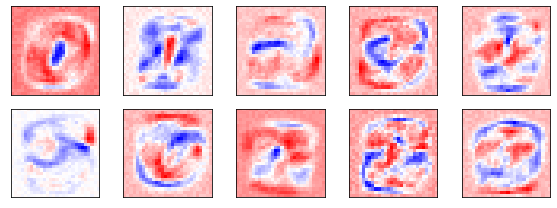

In [14]:
f, ax = plt.subplots(2,5, figsize=(8,3))
for i in range(5):
    ax[0, i].imshow(np.reshape(allweights[i,:], (28,28)), cmap='bwr')
    ax[1, i].imshow(np.reshape(allweights[i+5,:], (28,28)), cmap='bwr')

[a.axes.get_xaxis().set_visible(False) for a in ax.flatten()]
[a.axes.get_yaxis().set_visible(False) for a in ax.flatten()]
plt.tight_layout()

In [15]:
model.fc.bias

Parameter containing:
tensor([-0.5160,  0.2929,  0.1051, -0.2682, -0.0315,  0.8903, -0.1889,  0.4764,
        -1.0628, -0.2108], device='cuda:0', requires_grad=True)